# Classification Project: Predicting Cardiovascular Disease
***

**Author:** Ron Lodetti Jr.
![Heart](./images/heart.jpeg)

## Overview
***
This project uses machine learning and data from the CDC's [2021 Behavioral Risk Factor Surveillance System (BRFSS)](https://www.cdc.gov/brfss/annual_data/annual_2021.html) to help a hospital identify patients who would benefit from an educational program about heart health. After model iteration and hyperparameter tuning, our final model can **correctly predict about 81% of the people with a heart condition**, while only mislabeling about 29% of negative cases as positive. 

## Business Problem
***
Cardiovascular diseases are the [leading cause of death](https://en.wikipedia.org/wiki/List_of_causes_of_death_by_rate) worldwide except Africa. A hospital wants to be able to identify patients who are at risk of Cardiovascular disease (CVD) to begin taking preventative measures as early as possible. The hospital has developed a new online educational program and would like to recommend it to any patience at risk. 

## Data Understanding
***
This dataset, [from kaggle](https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset), is a cleaned version of the responses from the CDC's [2021 Behavioral Risk Factor Surveillance System (BRFSS)](https://www.cdc.gov/brfss/annual_data/annual_2021.html)

In [1]:
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, OrdinalEncoder, 
                                   StandardScaler)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

# Set seaborn context and style
sns.set(context='notebook',
       style = 'whitegrid')

In [2]:
# Loading the datasets.
df = pd.read_csv('data/Cardiovascular_Diseases_Risk_Prediction_Dataset.csv')
print(df.shape)
df.head()

(308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


As you can see, we have 308,854 rows, each with 18 feature columns and 1 target column:

* `General_Health`: Respondent's reported general health
* `Checkup`: Time since respondent's last routine checkup
* `Exercise`: Participation in any physical activities or exercises in the past month
* `Heart_Disease`: **(Target)** Respondents that reported having coronary heart disease or myocardial infarction
* `Skin_Cancer`: Respondents that reported having skin cancer
* `Other_Cancer`: Respondents that reported having any other types of cancer
* `Depression`: Respondents that reported having a depressive disorder
* `Diabetes`: Respondents that reported having a diabetes
* `Arthritis`: Respondents that reported having an Arthritis
* `Sex`: Respondent's Gender
* `Age_Category`: Respondent's Age, by category
* `Height_(cm)`: Respondent's Height in centimeters
* `Weight_(kg)`: Respondent's Weight in kilograms
* `BMI`: Body Mass Index
* `Smoking_History`: Respondents that reported having a history of smoking cigarettes
* `Alcohol_Consumption`: Number of days, in the past 30 days, where respondent has had at least one alcoholic beverage
* `Fruit_Consumption`: Number of servings of fruit during the past 30 days
* `Green_Vegetables_Consumption`: Number of servings of vegetables during the past 30 days
* `FriedPotato_Consumption`: Number of servings of fruit during the past 30 days

In [3]:
# There are no missing values. 
# There are 12 features which are object types, 
# we will need to convert these to numeric types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

This data set includes 12 categorical variables (including the target `Heart_Disease`) and 7 numeric variables.

In [4]:
categorical = list(df.select_dtypes(object).columns)
for i in categorical:
    print(i)
    print(df[i].value_counts())
    print('----------\n')

General_Health
Very Good    110395
Good          95364
Excellent     55954
Fair          35810
Poor          11331
Name: General_Health, dtype: int64
----------

Checkup
Within the past year       239371
Within the past 2 years     37213
Within the past 5 years     17442
5 or more years ago         13421
Never                        1407
Name: Checkup, dtype: int64
----------

Exercise
Yes    239381
No      69473
Name: Exercise, dtype: int64
----------

Heart_Disease
No     283883
Yes     24971
Name: Heart_Disease, dtype: int64
----------

Skin_Cancer
No     278860
Yes     29994
Name: Skin_Cancer, dtype: int64
----------

Other_Cancer
No     278976
Yes     29878
Name: Other_Cancer, dtype: int64
----------

Depression
No     246953
Yes     61901
Name: Depression, dtype: int64
----------

Diabetes
No                                            259141
Yes                                            40171
No, pre-diabetes or borderline diabetes         6896
Yes, but female told only during p

Of our 12 categorical variables:
* There are 8 variables that have no order to them and will need to be OneHotEncoded.
* There are 3 ordinal variables, that is, categories which have an order. These include `General_Health`, `Checkup`, and `Age_Category`.

I also notice that over 2/3 of the people (although not necesarily the same people) exercise and do not have a heart disease, skin cancer, other cancer, diabetes, depression, nor arthritis.

In [5]:
# Identifying ordinal variables and removing them from categorical
ordinal = ['General_Health', 'Checkup', 'Age_Category']
for i in ordinal:
    categorical.remove(i)
categorical.remove('Heart_Disease')

In [6]:
# These numeric variables are scaled differently and will need to be 
# scaled before including them in specific models

numeric = list(df.select_dtypes(exclude=object).columns)
df[numeric].describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


- Max and min values seem reasonable given context. 
- Based on the quartiles and the mean, it appears that `Alcohol_Consumption` might be positively skewed.

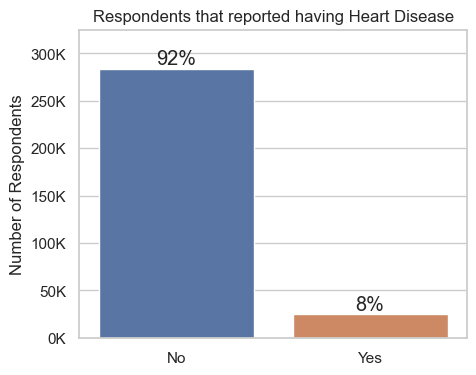

In [7]:
# importing code from as module
from code.my_module import viz_1
viz_1(df)

Our target variable is very imbalanced. We'll need to be sure to address this during data prep, modeling and evaluation.

Here is a visual representation illustrating the disparity in heart disease rates between individuals with a specific feature and those without it. 

For instance, approximately 6.06% of individuals without diabetes report experiencing a heart condition, whereas the rate is approximately 20.85% for those with diabetes, resulting in a substantial difference of approximately 14.79%.

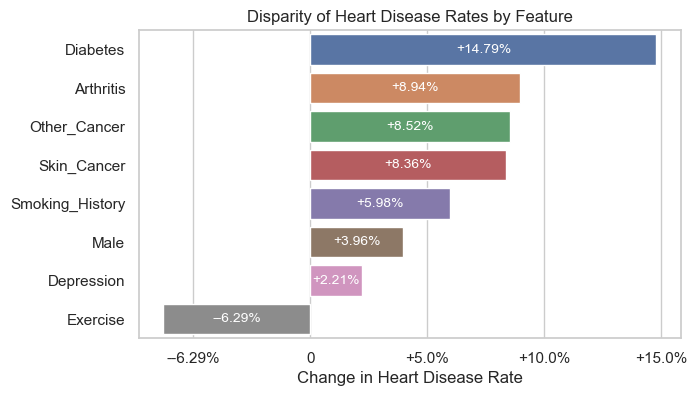

In [8]:
from code.my_module import viz_2
viz_2(df, categorical)

- People with most of these features are more likely to also have Heart Disease
- Men are more likely to report having Heart Disease than women
- Exercise is the only feature listed that has a negative relationship with Heart Disease.

## Data Preparation
***
The first step in our data preparation is to split the data in to test and train sets. We need to be careful to only use the test data as the last step in the evaluation process to avoid data leakage. 

In [9]:
# Splitting the training from the validation data
# Making sure the split is stratefied given the imbalance of our target variable
y = df['Heart_Disease']
X = df.drop('Heart_Disease', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=12,stratify=y)

print('Training Target Distribution')
print(y_train.value_counts(normalize=True))
print('')
print('Validation Target Distribution')
print(y_test.value_counts(normalize=True))

Training Target Distribution
No     0.91915
Yes    0.08085
Name: Heart_Disease, dtype: float64

Validation Target Distribution
No     0.919147
Yes    0.080853
Name: Heart_Disease, dtype: float64


In [10]:
# Transforming the target variable into 1's and 0's
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [11]:
# Listing categories in order for each ordinal variable.
health = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
check = [
    'Never', '5 or more years ago', 'Within the past 5 years',
    'Within the past 2 years', 'Within the past year'
]
age = [
    '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
    '60-64', '65-69', '70-74', '75-79', '80+'
]

# Instantiating an OrdinalEncoder transformer to encode ordinal variables.
oe = OrdinalEncoder(categories=[health, check, age])

In [12]:
# Instantiating a OneHotEncoder transformer to be used on the categorical varaibles. 
ohe = OneHotEncoder(handle_unknown='ignore')

In [13]:
# Instantiating a StandardScaler transformer for models which need scaling. 
ss = StandardScaler()

In [14]:
# Creating a column transformer to be used in a pipeline
ct = ColumnTransformer(transformers=[('oe', oe, ordinal),
                                     ('ohe', ohe, categorical)],
                       remainder="passthrough")

## Data Modeling
***
Since our stakeholder wants to identify as many people as possible who could have a heart condition and the cost of a false positive (identifying a person as likely to have a heart condition when they will not) is low, then we should **prioritize the true positive rate, or recall**. Given the imbalance in our dataset, I will use the f2-score as my evaluation metric. This is a weighted harmonic mean between precision and recall which gives more weight to recall.

Additionally, I will use pipelines when cross-validating and scoring my data as to avoid data leakage. 

### Dummy Model
We will start with a dummy model which always predicts the most frequent target value. In this case it will predict everyone **does not** have a heart condition.

In [15]:
# Importing a helper code that takes in a fitted model, cross-validates, scores, 
# and outputs a summary.
from code.my_module import model_scores

dummy_pipe = Pipeline(steps=[
    ('ct', ct),  # transforming ordinal and categorical variables
    ('dm', DummyClassifier(strategy='most_frequent'))
])

dummy_model = dummy_pipe.fit(X_train, y_train)

ml, mdf = model_scores(
    dummy_model, X_train, y_train, model_list=[], model_name='Dummy Model')
mdf

,name,f2,accuracy,precision,recall,roc_auc
0,Dummy Model,0.0,91.92,0.0,0.0,50.0


No surprise the accuracy is so high given the imbalance in the dataset. The ROC AUC score is also at 50 which is expected. 

### Baseline Model

I will use Logisitic Regression as a baseline model to compare future models to. 

In [16]:
# Creating and scoring our baseline model.
base_pipe = Pipeline(
        steps=[('ct', ct),
               ('ss', ss),  # LogisticRegression needs data to be scaled
               ("logreg", LogisticRegression(random_state=12))])
baseline_model = base_pipe.fit(X_train, y_train)
ml, mdf = model_scores(
    baseline_model, X_train, y_train, model_list=ml, model_name='Baseline Model')
mdf

,name,f2,accuracy,precision,recall,roc_auc
0,Dummy Model,0.0,91.92,0.00,0.00,50.00
1,Baseline Model,7.5,91.94,51.39,6.18,83.41


It performed slightly better than our dummy model, but not by much. It is still only capturing about 6.2% of the true positives. I think this model is having difficulties with the imbalance of the target variable. 

### Model Iteration

Next, I want to look two ensemble methods to help me which to use for our final model.

In [17]:
classifiers = {
    'RandomForestClassifier': RandomForestClassifier(random_state=12),
    'XGBClassifier': XGBClassifier(random_state=12)
}
ensemble_ml = []
for key in classifiers:
    classifier = classifiers[key]
    ensemble_pipe = Pipeline(steps=[('ct', ct), (key, classifier)])
    ensemble_model = ensemble_pipe.fit(X_train, y_train)
    ensemble_ml, ensemble_df = model_scores(
        ensemble_model, X_train, y_train, model_list=ensemble_ml, model_name=key)
ensemble_df

,name,f2,accuracy,precision,recall,roc_auc
0,RandomForestClassifier,5.34,91.81,43.76,4.38,80.85
1,XGBClassifier,6.22,91.89,48.57,5.10,82.99


XGBClassifier has slightly better metrics. Additionally it ran much more quickly, which will be helpful when hypertuning.

Next, I want to try three different methods for handling our target imbalance and compare them to a basic model. 

In [18]:
# Choose between XGBClassifier Variants

# Basic model for comparison
xgb_pipe = Pipeline(steps=[('ct', ct), ('xgb', XGBClassifier(random_state=12))])
xgb_model = xgb_pipe.fit(X_train, y_train)


# Using the scale_pos_weight parameter to add weight to the minority class.
# The specific number used is the ratio of negative class to the positive class.
num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()
neg_pos_ratio = num_negatives / num_positives

weighted_pipe = Pipeline(
    steps=[('ct',ct),
           ('xgb',XGBClassifier(random_state=12, scale_pos_weight=neg_pos_ratio))])
xgb_weighted = weighted_pipe.fit(X_train, y_train)

# Using SMOTE to oversample the positive class.
smote_pipe = ImPipeline(steps=[('ct', ct), ('ss', StandardScaler()), ('sm', SMOTE(
        random_state=12)), ('xgb', XGBClassifier(random_state=12))])
xgb_smote = smote_pipe.fit(X_train, y_train)

# Using ADASYN to oversample the positive class.
adasyn_pipe = ImPipeline(
    steps=[('ct', ct), ('ss', StandardScaler()), ('sm', ADASYN(
        random_state=12)), ('xgb', XGBClassifier(random_state=12))])
xgb_adasyn = adasyn_pipe.fit(X_train, y_train)

In [19]:
# Score XGB variant models
variant_dic = {
    'Basic XGB': xgb_model,
    'Weighted XGB': xgb_weighted,
    'SMOTE XGB': xgb_smote,
    'ADASYN XGB': xgb_adasyn
}
variant_ml = []
for num, key in enumerate(variant_dic):
    model = variant_dic[key]
    variant_ml, variant_df = model_scores(
        model, X_train, y_train, model_list=variant_ml, cv=5, model_name=key)
variant_df

,name,f2,accuracy,precision,recall,roc_auc
0,Basic XGB,6.22,91.89,48.57,5.10,82.99
1,Weighted XGB,49.27,74.52,20.62,75.49,82.41
2,SMOTE XGB,6.75,91.81,44.54,5.57,82.81
3,ADASYN XGB,6.03,91.79,43.35,4.97,82.85


The Weighted XGBClassifier siginicantly outperformed the others in both metrics and speed. 

#### Hyperparameter Tuning
I will start by using RandomizedSearchCV to randomly select parameters within ranges, scoring them, then searching for the parameters which produce the best f2-score. 

To save computation time I've pickled the results from the best model the search found. For more information, you can find the [code here.](./code/my_module.py)

In [20]:
# pipe and parameter ranges used in RandomizedSearchCV
rs_pipe = Pipeline(steps=[('ct', ct),
                       ('xbg',
                        XGBClassifier(random_state=12,
                                      tree_method='hist', 
                                      scale_pos_weight=neg_pos_ratio))])

params = {
    'xbg__n_estimators': range(50, 1000, 50),
    'xbg__max_depth': range(1, 15),
    'xbg__eta': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'xbg__colsample_bytree': np.linspace(0, 1, 50),
    'xbg__min_child_weight': range(1, 10),
    'xbg__gamma': [0, 0.1, 1, 10, 100, 1000],
    'xbg__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'xbg__reg_lambda': [0, 0.01, 0.1, 1, 10]
}

# parameters for best estimator
with open('pickles/rs_params.pkl', 'rb') as h:
    rs_params = pickle.load(h)

# scores best estimators from searches
with open('pickles/df5.pkl', 'rb') as g:
    search_scores_df = pickle.load(g)

print('Parameters for Best Model:')
display(pd.Series(rs_params))
print('')
print('Best Model Scores:')
display(search_scores_df.head(1))

Parameters for Best Model:


xbg__reg_lambda           10.000000
xbg__reg_alpha             0.100000
xbg__n_estimators        650.000000
xbg__min_child_weight      1.000000
xbg__max_depth             4.000000
xbg__gamma                10.000000
xbg__eta                   0.150000
xbg__colsample_bytree      0.428571
dtype: float64


Best Model Scores:


,name,f2,accuracy,precision,recall,roc_auc
0,Best Estimator from RS,50.32,72.72,20.18,80.33,83.63


Now I will use these parameters and see if I can improve the f2-score by manipulating n_estimators, max_depth, and learning rate parameters and using GridSearchCV to score every combination of parameters from the options given. 

Once again, I've pickled the results from the best model the search found. For more information, you can find the [code here.](./code/my_module.py)

In [21]:
# Classifier, pipe, and parameter ranges used in the GridSearchCV
xgb = XGBClassifier(reg_lambda=10,
                    reg_alpha=0.1,
                    min_child_weight=1,
                    gamma=10,
                    colsample_bytree=3 / 7,
                    tree_method="hist",
                    scale_pos_weight=neg_pos_ratio,
                    random_state=12)

gs_pipe = Pipeline(steps=[('ct', ct), ('xbg', xgb)])

params = {
    'xbg__n_estimators': np.linspace(400, 800, 10, dtype=int),
    'xbg__max_depth': [2, 3, 4, 5, 6, 7],
    'xbg__eta': np.linspace(0.1, 0.2, 10)
}

# parameters for best estimator
with open('pickles/gs_params.pkl', 'rb') as h:
    gs_params = pickle.load(h)

# loading the saved best model found during the grid search
with open('pickles/gs_model.pkl', 'rb') as h:
    gs_model = joblib.load(h)

print('Parameters for Best Model:')
display(pd.Series(gs_params))
print('')
print('Best Model Scores:')
display(search_scores_df)

Parameters for Best Model:


xbg__eta               0.1
xbg__max_depth         2.0
xbg__n_estimators    400.0
dtype: float64


Best Model Scores:


,name,f2,accuracy,precision,recall,roc_auc
0,Best Estimator from RS,50.32,72.72,20.18,80.33,83.63
1,Best Estimator from GS,50.46,72.82,20.26,80.44,83.65


Grid searching helped improve metrics across the board!

In [22]:
# Saving optimal parameters for future use.
xgb_final = XGBClassifier(eta=0.1,
                          max_depth=2,
                          n_estimators=400,
                          reg_lambda=10,
                          reg_alpha=0.1,
                          min_child_weight=1,
                          gamma=10,
                          colsample_bytree=3 / 7,
                          tree_method="hist",
                          scale_pos_weight=neg_pos_ratio,
                          random_state=12)

### Feature Importance

Looking at feature importances could help the hospital determine which questions on the questionare to include, and which to omit. It is important to remember that these figures represent the importance of these features **to the specific** model.

In [23]:
# Making a dataframe with the feature name and its importance.
feature_importances = gs_model.named_steps['xbg'].feature_importances_
feature_names = gs_model[:-1].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)
importance_df

,Feature,Importance
2,oe__Age_Category,0.194362
16,ohe__Arthritis_Yes,0.159462
0,oe__General_Health,0.153559
13,ohe__Diabetes_Yes,0.120359
11,ohe__Diabetes_No,0.077498
19,ohe__Smoking_History_No,0.051027
15,ohe__Arthritis_No,0.041956
18,ohe__Sex_Male,0.039063
17,ohe__Sex_Female,0.038595
1,oe__Checkup,0.026356


While we could make some conclusions about feature importance, it would be more helpful to have the original features as they correspond to questions on the questionaire. For example, instead of knowing `ohe__Arthritis__Yes` has an importance of about 0.159 and `ohe__Arthritis_No` has about 0.042, it would be easier to interpret and compare if these were combined into one feature, `Arthritis` with an importance of about 0.159 + 0.042 = 0.201. 

In [24]:
# This will clean the feature names back to the original feature names
def clean_features(feature):
    feats = df.columns
    for i in feats:
        if i in feature:
            return i
        else:
            pass

importance_df['Feature'] = importance_df['Feature'].apply(clean_features)

# Combining the features and adding their importance
importance_grouped_df = importance_df.groupby('Feature').sum().sort_values('Importance', ascending=False)
importance_grouped_df

,Importance
Feature,
Arthritis,0.201418
Diabetes,0.199771
Age_Category,0.194362
General_Health,0.153559
Sex,0.077658
Smoking_History,0.075105
Checkup,0.026356
Depression,0.019750
Skin_Cancer,0.012702


Let's see this visually.

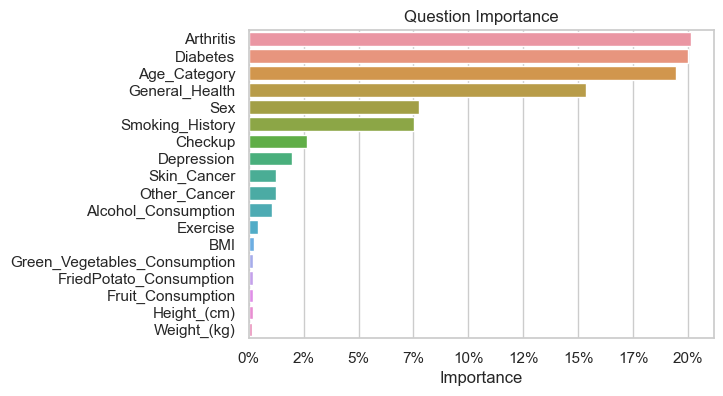

In [25]:
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.barplot(x=importance_grouped_df['Importance'], y=importance_grouped_df.index)
ax.set(ylabel = '',title = 'Question Importance')
ax.xaxis.set_major_formatter(lambda x, pos: f'{int(x*100)}%');

`Arthritis`, `Diabetes`, `Age`, `General_Health` are the most important features, with `Sex` and `Smoking_History` in the next tier of importance. 

Given that some features are significantly more important than others, let's construct and evaluate the model by initially considering the feature with the highest importance and subsequently incorporating additional features one at a time to assess their impact on the metrics.

In [26]:
def feature_selector(features, X_train, y_train, num, ml):
    """
    This function constructs and evaluates the model by initially considering 
    the feature with the highest importance and subsequently incorporating 
    additional features one at a time to assess their impact on the metrics.
    """
    ord_dic = {'General_Health': health, 'Checkup': check, 'Age_Category': age}
    to_ohe = []
    to_oe = []
    categories = []
    feats = features[:num]
    X_alt = X_train[feats]

    for c_feat in categorical:
        if c_feat in feats:
            to_ohe.append(c_feat)

    for o_feat in ordinal:
        if o_feat in feats:
            to_oe.append(o_feat)
            categories.append(ord_dic[o_feat])

    if len(to_ohe) > 0 and len(to_oe) > 0:
        ct = ColumnTransformer(transformers=[
            ('oe', OrdinalEncoder(categories=categories), to_oe),
            ('ohe', OneHotEncoder(), to_ohe)
        ], remainder="passthrough")
    elif len(to_ohe) > 0:
        ct = ColumnTransformer(transformers=[
            ('ohe', OneHotEncoder(), to_ohe)], remainder="passthrough")
    else:
        ct = ColumnTransformer(transformers=[
            ('oe', OrdinalEncoder(categories=categories), to_oe)
        ], remainder="passthrough")

    if len(to_ohe) > 0 or len(to_oe) > 0:
        pipe = Pipeline(steps=[('ct', ct), ('xbg', xgb_final)])
    else:
        pipe = Pipeline(steps=[('xbg', xgb_final)])

    model = pipe.fit(X_alt, y_train)
    ml, mdf = model_scores(model, X_alt, y_train, model_list=ml, cv=10, model_name='Top ' + str(num) + ' ' + 'features')
    return ml, mdf


In [27]:
selector_ml = []
for i in range(len(importance_grouped_df.index)):
    selector_ml, selector_df = feature_selector(
        importance_grouped_df.index, X_train, y_train, num=i + 1, ml=selector_ml)
selector_df.sort_values('f2', ascending=False)

,name,f2,accuracy,precision,recall,roc_auc
16,Top 17 features,50.46,72.96,20.32,80.21,83.61
13,Top 14 features,50.45,72.85,20.27,80.38,83.61
17,Top 18 features,50.40,72.90,20.27,80.19,83.61
12,Top 13 features,50.37,72.75,20.21,80.37,83.60
15,Top 16 features,50.36,72.90,20.26,80.12,83.58
14,Top 15 features,50.34,72.80,20.22,80.24,83.59
11,Top 12 features,50.33,72.73,20.19,80.32,83.58
10,Top 11 features,50.31,72.65,20.15,80.40,83.58
9,Top 10 features,50.25,72.57,20.10,80.42,83.52
7,Top 8 features,50.17,72.57,20.07,80.25,83.46


The model with 6 features is good balance between metrics and number of questions. We'll make this our final model.

In [28]:
# Importing a custom transformer which will drop the Weight_(kg) column.
from code.my_module import ColumnDropperTransformer

to_drop = [
    'Checkup', 'Depression', 'Skin_Cancer', 'Other_Cancer',
    'Alcohol_Consumption', 'Exercise', 'BMI', 'Green_Vegetables_Consumption',
    'FriedPotato_Consumption', 'Fruit_Consumption', 'Height_(cm)',
    'Weight_(kg)'
]
categorical2 = ['Arthritis', 'Diabetes', 'Sex', 'Smoking_History']
oe2 = OrdinalEncoder(categories=[age, health])
ordinal2 = ['Age_Category', 'General_Health']

# Making a new ColumnTransformer to incorporate the ColumnDropperTransformer
ct2 = ColumnTransformer(transformers=[
    ('cd', ColumnDropperTransformer(columns=to_drop), to_drop),
    ('oe', oe2, ordinal2), ('ohe', ohe, categorical2)
],
                        remainder="passthrough")

final_pipe = Pipeline(steps=[('ct2', ct2), ('xgb', xgb_final)])
final_model = final_pipe.fit(X_train, y_train)

In [29]:
ml, mdf = model_scores(final_model, X_train, y_train, model_list=ml, model_name='Final Model')
mdf

,name,f2,accuracy,precision,recall,roc_auc
0,Dummy Model,0.00,91.92,0.00,0.00,50.00
1,Baseline Model,7.50,91.94,51.39,6.18,83.41
2,Final Model,49.87,72.25,19.86,80.14,83.27


## Evaluation
***
Now that we have found the final model, I will score each of our models on the test data. 

In [30]:
models_dic = {
    'Dummy Model': dummy_model,
    'Baseline Model': baseline_model,
    'Final Model': final_model
}
ml = []
for num, key in enumerate(models_dic):
    model = models_dic[key]
    ml, mdf = model_scores(
        model, X_test, y_test, model_list=ml, cv=0, model_name=key)
mdf

,name,f2,accuracy,precision,recall,roc_auc
0,Dummy Model,0.00,91.91,0.00,0.00,50.00
1,Baseline Model,7.70,91.89,48.65,6.36,52.88
2,Final Model,50.02,72.14,19.87,80.60,76.00


The final model was the best performing model on the test data, capturing almost 81% of all of the positive cases. Given the over 300,000 data entries, lack of data leakage, and cross-validation done during training, I'm confident that this model would generalize. 

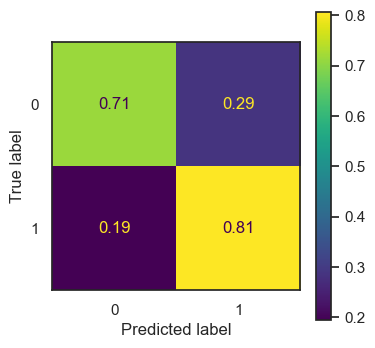

In [31]:
sns.set_style('white')
fig,ax= plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test,
                                        final_model.predict(X_test),
                                        normalize='true', 
                                        ax=ax);

Based on this confusion matrix our model would correctly predict 81% of positive cases and 71% of negative cases. It would incorrectly predict 29% of negative cases as positive and 19% of positive cases as negative. 

Next we can look at the ROC curve to view the relationship between the true positive rate and false positve rate across all classification thresholds. 

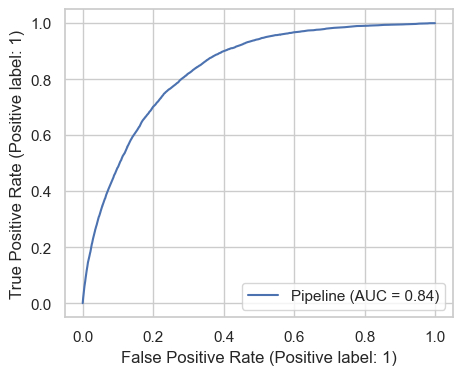

In [32]:
sns.set_style('whitegrid')
fig,ax= plt.subplots(figsize=(5,4))
RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=ax);

We may adjust the the classification threshold to meet the hospital's needs. 

For example, say we needed to correctly identify at least 90% of the positve cases. 

In [33]:
probabilities = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
desired_tpr = 0.9
idx = np.argmax(tpr >= desired_tpr)
threshold_at_desired_tpr = thresholds[idx]
threshold_at_desired_tpr

0.36459693

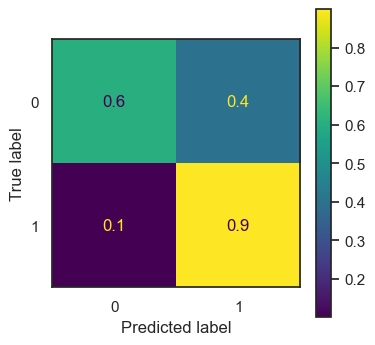

In [34]:
sns.set_style('white')
fig,ax= plt.subplots(figsize=(4,4))
# setting classification threshold to 0.36561492
predicted_labels = (probabilities > threshold_at_desired_tpr).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test,
                                        predicted_labels,
                                        normalize='true',
                                        ax=ax);

Now we are correctly predicting 90% of positive cases. This change decreased the rate that we correctly identify negative cases from 72% to 61% and increased the rate of incorrectly predicting negative cases as positive from 28% to 40%.

## Conclusions
***
### Recommendations
Based on our final model I would make the following recommendations:
1. Develop a 6-question questionaire which would include questions about:
    - Arthritis
    - Diabetes
    - Age
    - General Health
    - Sex
    - Smoking History
<br>
<br>
2. Use an XGBClassifier model with the following parameters:
    - eta: 0.1
    - max_depth: 2
    - n_estimators: 400
    - reg_lambda: 10
    - reg_alpha: 0.1
    - min_child_weight: 1
    - gamma: 10
    - colsample_bytree: 3/7
    - tree_method: "hist"
    - scale_pos_weight: 212912/18728


### Limitations
- This model would not be as helpful in cases where the cost of a positve identification is increased, such as recommending a more invasive procedure, medication, or otherwise more expensive or cumbersome consequence.   
### Next Steps
- Determine with stakeholders the appropriate threshold to balance out true positive rate and false positive rate.
- Gather more data to see if there are other features which may help predict having a heart condition.